In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

In [ ]:
# Load the dataset
data = pd.read_csv('feature_importance_synthetic_data.csv')

In [ ]:
data

,tradeHorizon,tradedValue,historicalVolatility,participationRate,percentMDV,spread,marketCap,sector,securityType,side,country,transactionCost
0,5.496714,106996.777183,0.432482,0.427496,0.090943,0.024045,9.311872e+07,Technology,Bond,Sell,UK,1.931877
1,4.861736,104623.168415,0.485548,0.493427,0.019013,0.017078,9.250932e+07,Technology,Stock,Buy,Canada,1.753041
2,5.647689,100298.151850,0.420758,0.203868,0.082125,0.016253,8.040149e+07,Finance,ETF,Sell,UK,1.928055
3,6.523030,96765.316111,0.469204,0.487889,0.054463,0.018892,6.085323e+07,Utilities,Bond,Sell,UK,2.222999
4,4.765847,103491.116568,0.310639,0.272494,0.007786,0.014115,8.663714e+07,Finance,Bond,Buy,Germany,1.674542
...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.718900,105350.751192,0.507748,0.413265,0.097744,0.023458,9.613145e+07,Utilities,Bond,Sell,Canada,1.711399
996,6.797687,99867.393704,0.525775,0.148999,0.096435,0.021366,1.043678e+08,Healthcare,Stock,Buy,UK,2.292907
997,5.640843,95590.626744,0.375824,0.353963,0.016373,0.015009,1.257773e+08,Technology,ETF,Sell,Canada,1.949144
998,4.428821,99184.665180,0.533418,0.149538,0.029942,0.019986,9.733994e+07,Technology,ETF,Sell,Germany,1.575536


# Step 1: Data Cleaning & Normalization

In [ ]:
data.isnull().sum()

,0
tradeHorizon,0
tradedValue,0
historicalVolatility,0
participationRate,0
percentMDV,0
spread,0
marketCap,0
sector,0
securityType,0
side,0


In [ ]:
# Remove rows with missing values or any other inconsistencies
data.dropna(inplace=True)

In [ ]:
# Normalize numeric columns for consistency
for column in ['tradeHorizon', 'tradedValue', 'historicalVolatility', 'participationRate', 'percentMDV', 'spread', 'marketCap']:
    data[column] = (data[column] - data[column].mean()) / data[column].std()

In [ ]:
data.head(5)

,tradeHorizon,tradedValue,historicalVolatility,participationRate,percentMDV,spread,marketCap,sector,securityType,side,country,transactionCost
0,0.487515,1.331910,-0.692470,1.147269,1.417203,0.836777,-0.297592,Technology,Bond,Sell,UK,1.931877
1,-0.160941,0.855976,-0.152882,1.723145,-1.065623,-0.575139,-0.327458,Technology,Stock,Buy,Canada,1.753041
2,0.641693,-0.011234,-0.811684,-0.806020,1.112832,-0.742236,-0.920849,Finance,ETF,Sell,UK,1.928055
3,1.535614,-0.719605,-0.319075,1.674778,0.158019,-0.207391,-1.878887,Utilities,Bond,Sell,UK,2.222999
4,-0.258866,0.628988,-1.931405,-0.206609,-1.453156,-1.175530,-0.615247,Finance,Bond,Buy,Germany,1.674542


# Step 2: Chunking Data

In [ ]:
data['chunk'] = data['securityType'] + '_' + data['side']

In [ ]:
data.head(5)

,tradeHorizon,tradedValue,historicalVolatility,participationRate,percentMDV,spread,marketCap,sector,securityType,side,country,transactionCost,chunk
0,0.487515,1.331910,-0.692470,1.147269,1.417203,0.836777,-0.297592,Technology,Bond,Sell,UK,1.931877,Bond_Sell
1,-0.160941,0.855976,-0.152882,1.723145,-1.065623,-0.575139,-0.327458,Technology,Stock,Buy,Canada,1.753041,Stock_Buy
2,0.641693,-0.011234,-0.811684,-0.806020,1.112832,-0.742236,-0.920849,Finance,ETF,Sell,UK,1.928055,ETF_Sell
3,1.535614,-0.719605,-0.319075,1.674778,0.158019,-0.207391,-1.878887,Utilities,Bond,Sell,UK,2.222999,Bond_Sell
4,-0.258866,0.628988,-1.931405,-0.206609,-1.453156,-1.175530,-0.615247,Finance,Bond,Buy,Germany,1.674542,Bond_Buy


# Step 3: Data Labeling & Splitting

In [ ]:
# Assume 'transactionCost' is the target variable
X = data.drop(columns=['transactionCost', 'chunk'])
y = data['transactionCost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Selecting Relevant Features

In [ ]:
# Based on domain knowledge, selecting relevant features for cost prediction
selected_features = ['tradeHorizon', 'tradedValue', 'historicalVolatility', 'participationRate', 'percentMDV']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Step 5: Model Selection & Training

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Evaluate model performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0009587222674064741


# Step 6: Feature Importance Calculation

### 1. Default scikit-learn Feature Importance

In [ ]:
feature_importance = dict(zip(selected_features, model.feature_importances_))
print(feature_importance)

{'tradeHorizon': 0.9935727266596955, 'tradedValue': 0.0011169455691395255, 'historicalVolatility': 0.0023190999115374864, 'participationRate': 0.0023660344217907433, 'percentMDV': 0.0006251934378367689}


<ipython-input-40-c197a5bd0376>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")


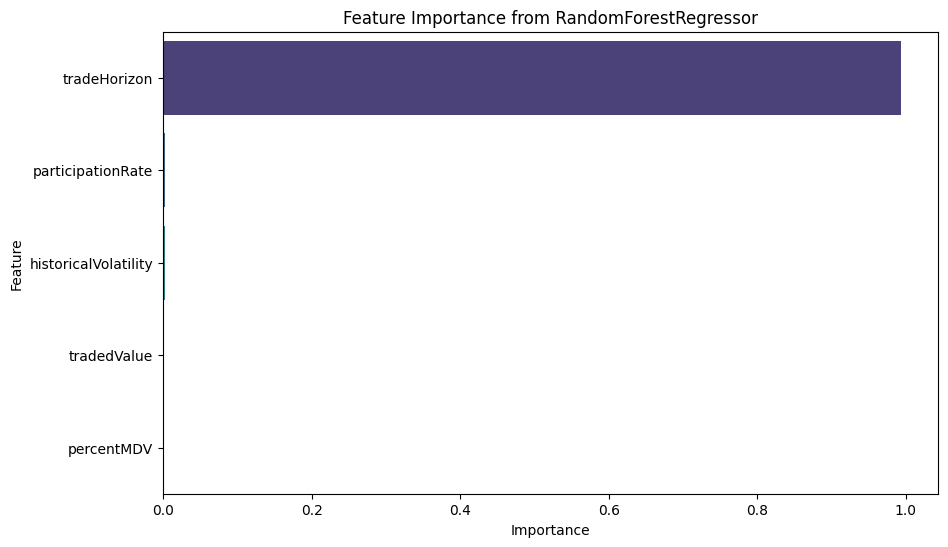

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train.columns instead of X.columns
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")
plt.title("Feature Importance from RandomForestRegressor")
plt.show()

### 2. Permutation Importance

<ipython-input-43-d90945eed738>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df, x='Importance', y='Feature', palette="coolwarm")


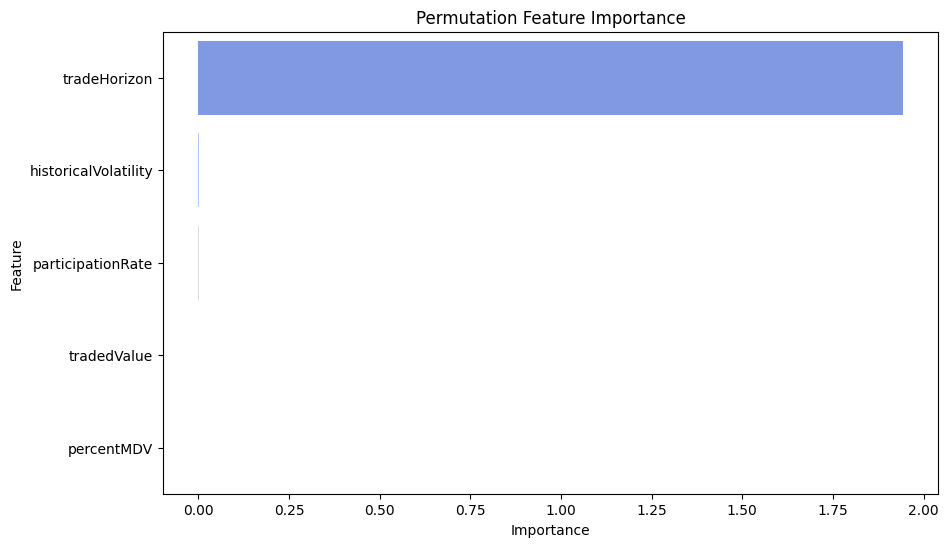

,Feature,Importance
0,tradeHorizon,1.942632
2,historicalVolatility,0.003189
3,participationRate,0.002953
1,tradedValue,0.000292
4,percentMDV,-0.000058


In [ ]:


perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,  # Use X_test.columns instead of X.columns
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot permutation feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importance_df, x='Importance', y='Feature', palette="coolwarm")
plt.title("Permutation Feature Importance")
plt.show()
perm_importance_df

In [ ]:
print("Top features by default feature importance:\n", importance_df.head())
print("\nTop features by permutation importance:\n", perm_importance_df.head())

Top features by default feature importance:
                 Feature  Importance
0          tradeHorizon    0.993573
3     participationRate    0.002366
2  historicalVolatility    0.002319
1           tradedValue    0.001117
4            percentMDV    0.000625

Top features by permutation importance:
                 Feature  Importance
0          tradeHorizon    1.942632
2  historicalVolatility    0.003189
3     participationRate    0.002953
1           tradedValue    0.000292
4            percentMDV   -0.000058


### 3. Drop Column Importance

In [ ]:

# Dropping each feature and re-evaluating
drop_importance = {}
for feature in selected_features:
    X_train_drop = X_train.drop(columns=[feature])
    X_test_drop = X_test.drop(columns=[feature])
    model.fit(X_train_drop, y_train)
    drop_pred = model.predict(X_test_drop)
    drop_mse = mean_squared_error(y_test, drop_pred)
    drop_importance[feature] = mse - drop_mse
print("Drop Column Importance:")
print(drop_importance)

Drop Column Importance:
{'tradeHorizon': -0.08538709628246283, 'tradedValue': 1.2051701599571961e-05, 'historicalVolatility': -0.00016395163952782855, 'participationRate': -0.0001463575629335374, 'percentMDV': 5.951458226904861e-05}


<ipython-input-48-566216cdc9b3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=drop_column_importance_df, x='Importance', y='Feature', palette="plasma")


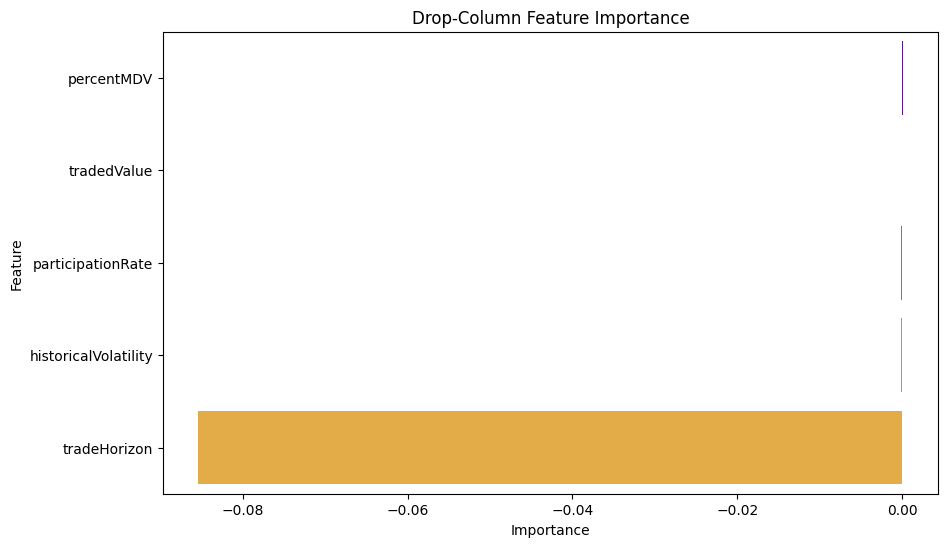

In [ ]:
# Plot drop-column feature importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'drop_importance' is the dictionary calculated previously
drop_column_importance_df = pd.DataFrame({
    'Feature': drop_importance.keys(),
    'Importance': drop_importance.values()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=drop_column_importance_df, x='Importance', y='Feature', palette="plasma")
plt.title("Drop-Column Feature Importance")
plt.show()

#### 4. SHAP Values (Shapley Additive Explanation)**bold text**

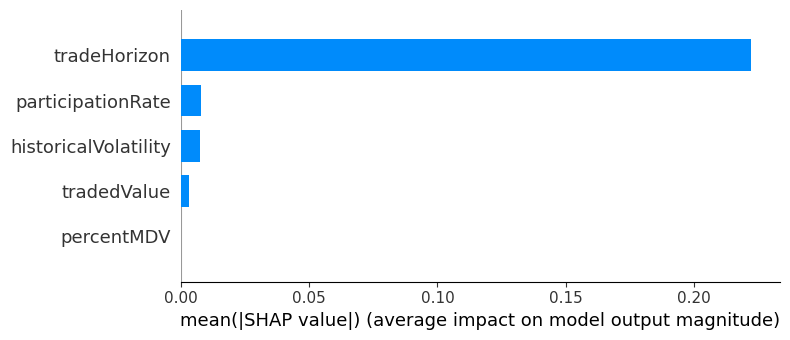

In [ ]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Insights:
# With these results, we can identify which features impact transaction costs the most.
# Based on the importance of features such as tradeHorizon and tradedValue,
# traders can use this model for pre-trade and post-trade analysis.